# Introducción 

El objetivo de este notebook es lograr predecir casos positivos de virus resporatorio sincicial en salud pública de Chile, sin chatGPT, para después hacer la comparación y mejoras que vienen de utilizar chatGPT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

# Preprocessing

## VRS

In [2]:
aux = pd.read_excel('Virus_respiratorios_general.xlsx')

In [3]:
aux.head()

,◢ Año,SE,Unnamed: 2,Adenovirus,Influenza A,Influenza B,Metapneumovirus,Parainfluenza,SARS-CoV-2,Virus Respiratorio Sincicial,Totales
0,◢ 2019,NaN,NaN,"1,820","3,944","2,592","1,464","2,514",NaN,"8,615","20,949"
1,◢ 2019,1,1,16,4,2,5,7,NaN,3,37
2,◢ 2019,2,2,16,4,9,3,8,NaN,4,44
3,◢ 2019,3,3,28,2,8,7,8,NaN,4,57
4,◢ 2019,4,4,11,6,3,1,6,NaN,5,32


In [4]:
aux1 = aux.drop(columns = ['Unnamed: 2','Adenovirus','Influenza B','Influenza A','Metapneumovirus','Parainfluenza','SARS-CoV-2','Totales' ])

Drop de las filas que tienen los totales por virus y subtotales por año

In [5]:
aux1

,◢ Año,SE,Virus Respiratorio Sincicial
0,◢ 2019,NaN,"8,615"
1,◢ 2019,1,3
2,◢ 2019,2,4
3,◢ 2019,3,4
4,◢ 2019,4,5
...,...,...,...
232,◢ 2023,19,748
233,◢ 2023,20,"1,073"
234,◢ 2023,21,"1,484"
235,◢ 2023,22,"1,728"


In [6]:
aux2 = aux1.drop(236)

In [7]:
aux2[aux2['SE']=='1']

,◢ Año,SE,Virus Respiratorio Sincicial
1,◢ 2019,1,3
54,◢ 2020,1,1
108,◢ 2021,1,1
161,◢ 2022,1,100
214,◢ 2023,1,40


In [8]:
drop_list = [0,53,107,160,213]
aux3 = aux2.drop(drop_list)

Fix formato de Año

In [9]:
aux3['Año'] = aux3['◢ Año'].str.replace('◢ ','')
aux3 = aux3.drop(columns='◢ Año')

In [10]:
import datetime
# Add current week
last_week = datetime.datetime(2023, 6, 9)
aux3.loc[236, 'Virus Respiratorio Sincicial'] = '1,729'
aux3.loc[236, 'SE'] = '23'
aux3.loc[236, 'Año'] = '2023'

Fix nulls

In [11]:
aux3.isna().sum()

SE                               0
Virus Respiratorio Sincicial    23
Año                              0
dtype: int64

In [12]:
aux3[aux3['Virus Respiratorio Sincicial'].isna()]

,SE,Virus Respiratorio Sincicial,Año
56,3,NaN,2020
61,8,NaN,2020
68,15,NaN,2020
69,16,NaN,2020
73,20,NaN,2020
77,24,NaN,2020
79,26,NaN,2020
80,27,NaN,2020
83,30,NaN,2020
87,34,NaN,2020


In [13]:
aux3 = aux3.fillna('0')

fix dtypes

In [14]:
aux3

,SE,Virus Respiratorio Sincicial,Año
1,1,3,2019
2,2,4,2019
3,3,4,2019
4,4,5,2019
5,5,2,2019
...,...,...,...
232,19,748,2023
233,20,"1,073",2023
234,21,"1,484",2023
235,22,"1,728",2023


In [15]:
# aux3['Influenza A'] = aux3['Influenza A'].astype(int)
aux3['Virus Respiratorio Sincicial'] = aux3['Virus Respiratorio Sincicial'].str.replace(',','').astype(int)

In [16]:
aux3

,SE,Virus Respiratorio Sincicial,Año
1,1,3,2019
2,2,4,2019
3,3,4,2019
4,4,5,2019
5,5,2,2019
...,...,...,...
232,19,748,2023
233,20,1073,2023
234,21,1484,2023
235,22,1728,2023


In [17]:
aux3.dtypes

SE                              object
Virus Respiratorio Sincicial     int64
Año                             object
dtype: object

In [18]:
# Plot the data
# sns.lineplot(data = aux3,x='SE',y='Influenza A', hue='Año')
# plt.title('Influenza A')

Text(0.5, 1.0, 'Virus Respiratorio Sincicial')

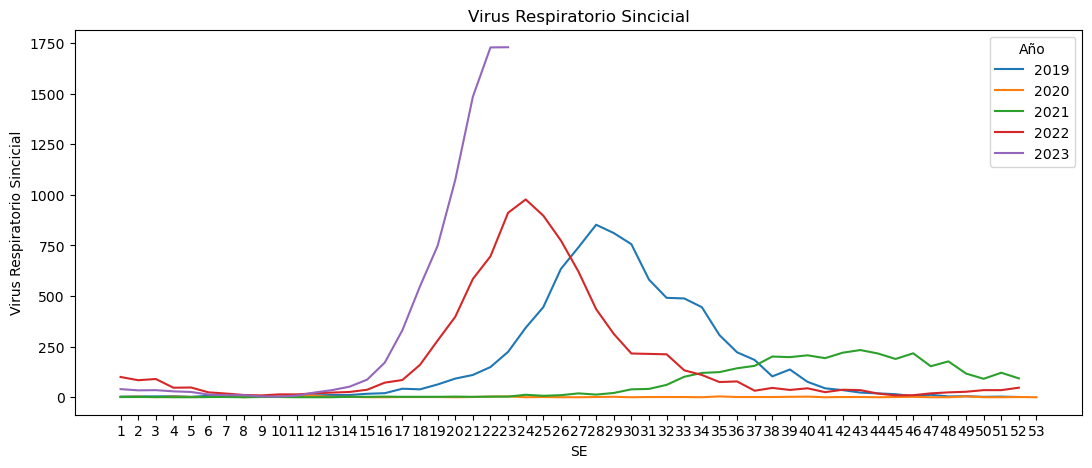

In [19]:
# Plot the data
plt.figure(figsize=(13,5))
sns.lineplot(data = aux3,x='SE',y='Virus Respiratorio Sincicial', hue='Año')
plt.title('Virus Respiratorio Sincicial')

In [20]:
aux3[aux3['Año']=='2020']

,SE,Virus Respiratorio Sincicial,Año
54,1,1,2020
55,2,3,2020
56,3,0,2020
57,4,3,2020
58,5,1,2020
59,6,1,2020
60,7,4,2020
61,8,0,2020
62,9,3,2020
63,10,3,2020


Vemos que 2020 no tiene casi nada de datos así que los borramos

In [21]:
aux4 = aux3.drop(aux3[aux3['Año']=='2020'].index)

In [22]:
aux4['Año'].value_counts()

2019    52
2021    52
2022    52
2023    23
Name: Año, dtype: int64

In [23]:
aux4.dtypes

SE                              object
Virus Respiratorio Sincicial     int64
Año                             object
dtype: object

In [24]:
aux4.shape

(179, 3)

In [25]:
aux4

,SE,Virus Respiratorio Sincicial,Año
1,1,3,2019
2,2,4,2019
3,3,4,2019
4,4,5,2019
5,5,2,2019
...,...,...,...
232,19,748,2023
233,20,1073,2023
234,21,1484,2023
235,22,1728,2023


In [26]:
aux4['date'] = aux4['Año'].astype(str)+'-'+aux4['SE'].astype(str)

aux4['date'] = pd.to_datetime(aux4['date']+'0', format = '%Y-%W%w')

# index pasa a ser SE para ver estacionalidad
aux4 = aux4.set_index('date')

In [27]:
# flu = aux4['Influenza A']
vrs = aux4['Virus Respiratorio Sincicial'].head(129)
vrs_test = aux4['Virus Respiratorio Sincicial'].tail(49)

# Modelos

## SARIMA 

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
# data = {
#     'positive_cases': [5, 6, 8, 13, 19, 27, 35, 48, 63, 78, 91, 105, 130, 150, 180, 210, 250, 300, 360, 400]
# }
# dates = pd.date_range(start='2020-01-01', periods=len(data['positive_cases']), freq='W')
# series = pd.Series(data['positive_cases'], index=dates)


In [30]:
# covid_train.DatetimeIndex= covid_train.index
# covid_train.DatetimeIndex
# covid_train.index.freq = 'W'

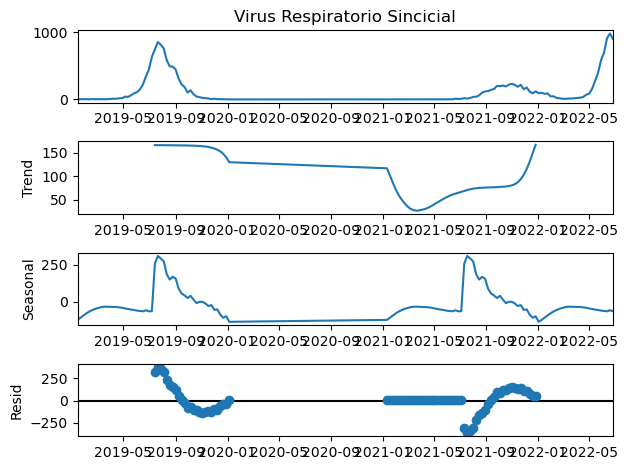

In [31]:
# Decompose the time series to visualize the trend and seasonality

# decomposition = seasonal_decompose(covid_train,)
decomposition = seasonal_decompose(vrs, period=52)
decomposition.plot()
plt.show()

In [32]:
# Fit a SARIMA model
# Note: p, d, q, P, D, Q, and S values need to be chosen based on your data.
# This example uses arbitrary values; for better results, it's essential to perform a grid search or similar to find optimal parameters.
p, d, q = 2, 1, 4  # Non-seasonal parameters
P, D, Q, S = 1, 1, 1, 12  # Seasonal parameters
sarima_model = SARIMAX(vrs, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_result = sarima_model.fit()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77415D+00    |proj g|=  1.48542D-01

At iterate    5    f=  4.72982D+00    |proj g|=  1.31176D-02

At iterate   10    f=  4.71899D+00    |proj g|=  8.47878D-03

At iterate   15    f=  4.70176D+00    |proj g|=  5.65559D-02

At iterate   20    f=  4.68394D+00    |proj g|=  7.38780D-03

At iterate   25    f=  4.66719D+00    |proj g|=  3.72469D-02

At iterate   30    f=  4.66373D+00    |proj g|=  3.75219D-03

At iterate   35    f=  4.66209D+00    |proj g|=  1.66083D-02

At iterate   40    f=  4.66080D+00    |proj g|=  5.12732D-04

At iterate   45    f=  4.66076D+00    |proj g|=  7.60679D-04

At iterate   50    f=  4.66074D+00    |proj g|=  6.61663D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# Make predictions
predict = sarima_result.predict()
# forecast_mean = forecast.predicted_mean
# forecast_conf_int = forecast.conf_int()

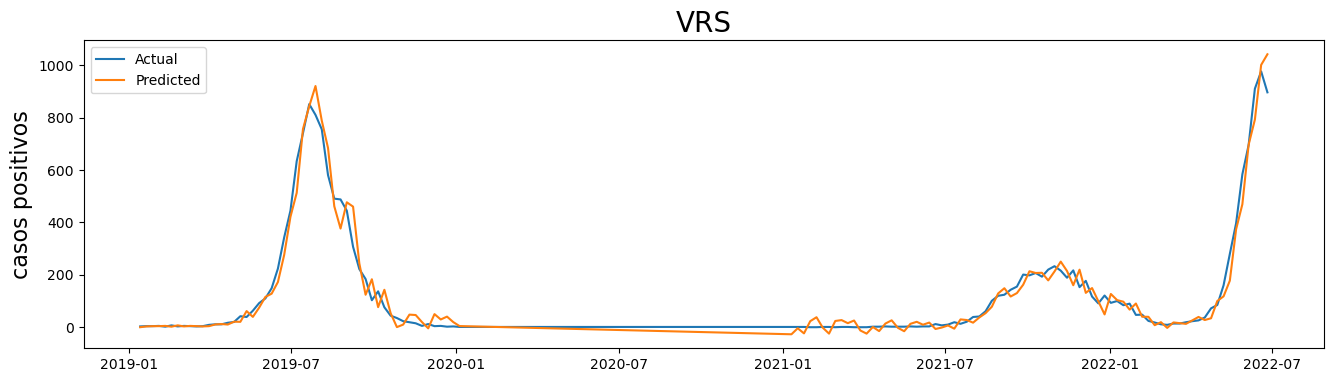

In [34]:
plt.figure(figsize=(16,4))
plt.plot(vrs, label="Actual")
plt.plot(predict, label="Predicted")
plt.title('VRS', fontsize=20)
plt.ylabel('casos positivos', fontsize=16)
plt.legend()

In [35]:
#forecast

forecast_weeks = 6
forecast = sarima_result.get_forecast(steps=forecast_weeks)
forecast_mean = forecast.predicted_mean

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [36]:
# Create a new index for the forecasted values based on the last date in the training data
last_date = vrs.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_weeks + 1, closed='right',freq='7D')
forecast_mean.index = forecast_dates

/tmp/ipykernel_6233/1946003586.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_weeks + 1, closed='right',freq='7D')


In [37]:
forecast_mean

2022-07-03    831.567481
2022-07-10    720.185117
2022-07-17    612.499473
2022-07-24    524.226858
2022-07-31    454.663336
2022-08-07    388.492358
Freq: 7D, Name: predicted_mean, dtype: float64

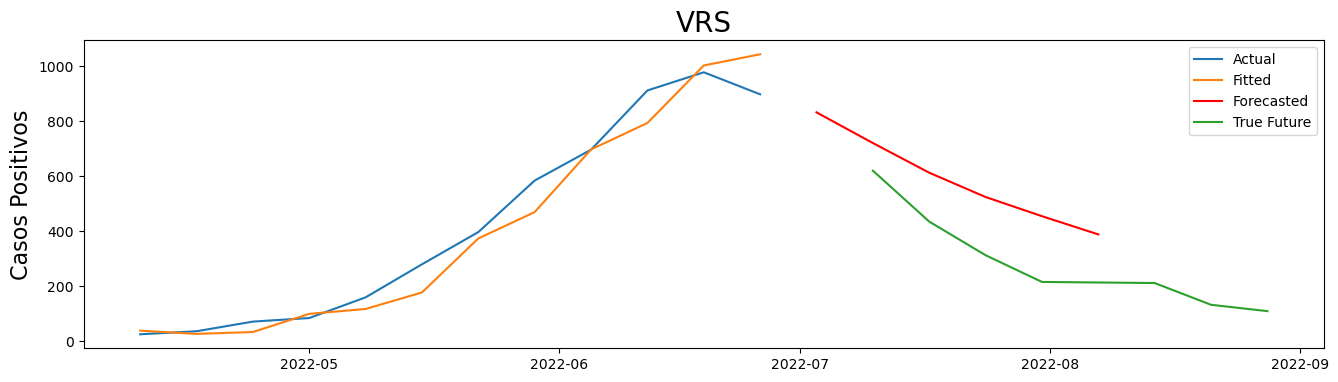

In [38]:
# Plot the results
plt.figure(figsize=(16, 4))
plt.plot(vrs.tail(12), label="Actual")
plt.plot(predict.tail(12), label="Fitted")
plt.plot(forecast_mean.index, forecast_mean.values, label="Forecasted", color='red')
plt.plot(vrs_test.head(8), label="True Future")
plt.title('VRS', fontsize=20)
plt.ylabel('Casos Positivos', fontsize=16)
plt.legend()
plt.show()

## 2023

In [39]:
vrs = aux4['Virus Respiratorio Sincicial']

In [40]:
# Fit a SARIMA model
# Note: p, d, q, P, D, Q, and S values need to be chosen based on your data.
# This example uses arbitrary values; for better results, it's essential to perform a grid search or similar to find optimal parameters.
p, d, q = 2, 1, 4  # Non-seasonal parameters
P, D, Q, S = 1, 1, 1, 12  # Seasonal parameters
sarima_model = SARIMAX(vrs, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_result = sarima_model.fit()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30591D+00    |proj g|=  7.05131D-01

At iterate    5    f=  4.99908D+00    |proj g|=  1.22318D-02

At iterate   10    f=  4.99178D+00    |proj g|=  6.11113D-03

At iterate   15    f=  4.97702D+00    |proj g|=  1.98325D-02

At iterate   20    f=  4.93066D+00    |proj g|=  5.91808D-02

At iterate   25    f=  4.92835D+00    |proj g|=  2.74884D-04

At iterate   30    f=  4.92832D+00    |proj g|=  4.86444D-03

At iterate   35    f=  4.91853D+00    |proj g|=  4.09339D-02

At iterate   40    f=  4.91581D+00    |proj g|=  1.96874D-03

At iterate   45    f=  4.91574D+00    |proj g|=  2.23783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [41]:
# Make predictions
predict = sarima_result.predict()
# forecast_mean = forecast.predicted_mean
# forecast_conf_int = forecast.conf_int()

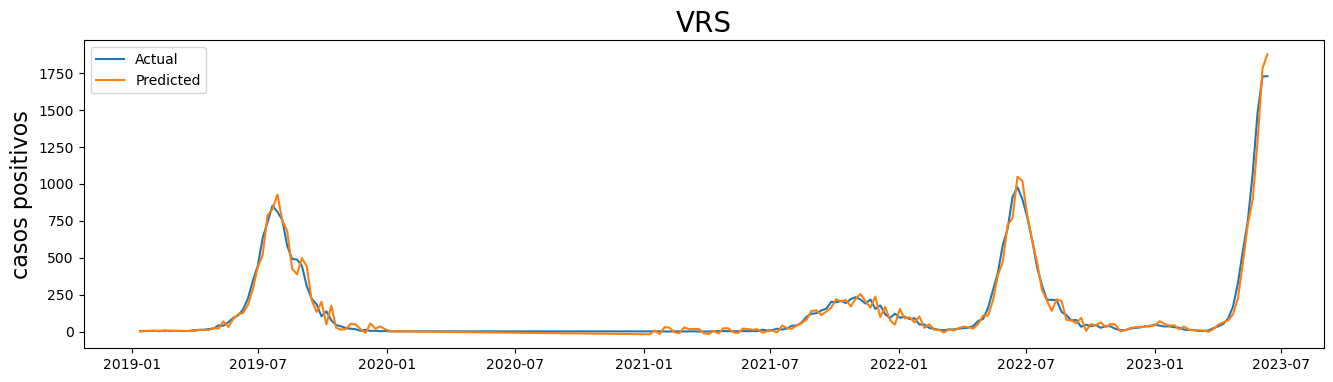

In [42]:
plt.figure(figsize=(16,4))
plt.plot(vrs, label="Actual")
plt.plot(predict, label="Predicted")
plt.title('VRS', fontsize=20)
plt.ylabel('casos positivos', fontsize=16)
plt.legend()

In [43]:
#forecast

forecast_weeks = 6
forecast = sarima_result.get_forecast(steps=forecast_weeks)
forecast_mean = forecast.predicted_mean

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
# Create a new index for the forecasted values based on the last date in the training data
last_date = vrs.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_weeks + 1, closed='right',freq='7D')
forecast_mean.index = forecast_dates

/tmp/ipykernel_6233/1946003586.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_weeks + 1, closed='right',freq='7D')


In [45]:
forecast_mean

2023-06-18    1651.980144
2023-06-25    1497.854337
2023-07-02    1320.235305
2023-07-09    1134.447807
2023-07-16     946.832701
2023-07-23     753.832341
Freq: 7D, Name: predicted_mean, dtype: float64

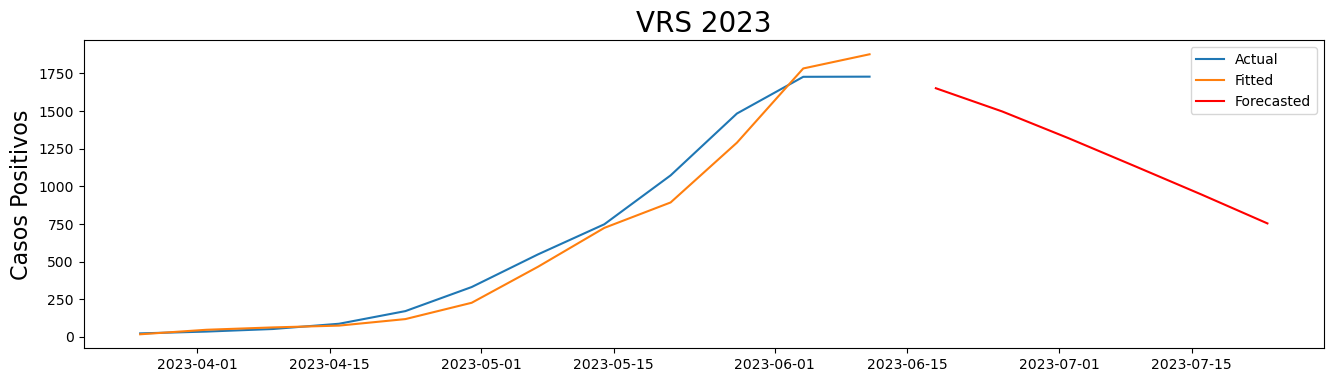

In [46]:
# Plot the results
plt.figure(figsize=(16, 4))
plt.plot(vrs.tail(12), label="Actual")
plt.plot(predict.tail(12), label="Fitted")
plt.plot(forecast_mean.index, forecast_mean.values, label="Forecasted", color='red')
# plt.plot(vrs_test.head(8), label="True Future")
plt.title('VRS 2023', fontsize=20)
plt.ylabel('Casos Positivos', fontsize=16)
plt.legend()
plt.show()

## LSTM

In [47]:
# df = covid_df.reset_index()[['date','Número de confirmados']]
# timeseries = df[["Número de confirmados"]].values.astype('float32')


timeseries = vrs.values.astype('float32')

In [48]:
from sklearn.preprocessing import MinMaxScaler


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries = scaler.fit_transform(timeseries.reshape(-1, 1))

In [49]:
# train-test split for time series8
train_size = int(len(timeseries) * 0.95)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 

In [50]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 

In [51]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 

/tmp/ipykernel_6233/3750763722.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y)


In [52]:
X_train.shape

torch.Size([166, 4, 1])

In [53]:
y_train.shape

torch.Size([166, 4, 1])

In [54]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=200, num_layers=1, batch_first=True)
        self.linear = nn.Linear(200, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 

In [55]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=32)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
#     for X_batch, y_batch in loader:
    for batch, (X_batch,y_batch) in enumerate(loader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
#         print(y_pred.shape)
#         print('...')
#         print(y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 

Epoch 0: train RMSE 0.1254, test RMSE 0.5659
Epoch 100: train RMSE 0.0235, test RMSE 0.1250
Epoch 200: train RMSE 0.0228, test RMSE 0.1170
Epoch 300: train RMSE 0.0223, test RMSE 0.1139
Epoch 400: train RMSE 0.0218, test RMSE 0.1135
Epoch 500: train RMSE 0.0213, test RMSE 0.1136
Epoch 600: train RMSE 0.0211, test RMSE 0.1127
Epoch 700: train RMSE 0.0210, test RMSE 0.1113
Epoch 800: train RMSE 0.0210, test RMSE 0.1133
Epoch 900: train RMSE 0.0209, test RMSE 0.1109
Epoch 1000: train RMSE 0.0208, test RMSE 0.1085
Epoch 1100: train RMSE 0.0208, test RMSE 0.1084
Epoch 1200: train RMSE 0.0207, test RMSE 0.1061
Epoch 1300: train RMSE 0.0206, test RMSE 0.1079
Epoch 1400: train RMSE 0.0205, test RMSE 0.1069
Epoch 1500: train RMSE 0.0205, test RMSE 0.1080
Epoch 1600: train RMSE 0.0204, test RMSE 0.1098
Epoch 1700: train RMSE 0.0203, test RMSE 0.1092
Epoch 1800: train RMSE 0.0203, test RMSE 0.1095
Epoch 1900: train RMSE 0.0203, test RMSE 0.1123


In [56]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
    

# with torch.no_grad():
#     # shift train predictions for plotting
#     train_plot = np.ones_like(timeseries) * np.nan
#     y_pred = model(X_train)
#     print(y_pred.shape)
#     y_pred = y_pred[:, -1, :]
#     print(y_pred.shape)
#     train_plot[lookback+3:train_size] = model(X_train)[:, -1, 3].reshape(train_size-lookback-3,1)
#     # shift test predictions for plotting
#     test_plot = np.ones_like(timeseries) * np.nan
#     test_plot[train_size+lookback+3:len(timeseries)] =model(X_test)[:, -1, 3].reshape(test_size-lookback-3,1)
    
#     future_plot=model(y_test[-1])
    
    

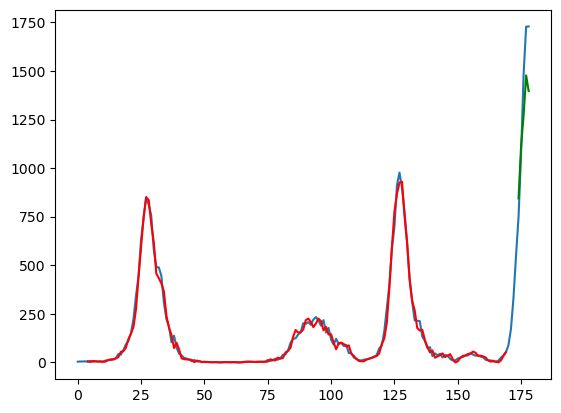

In [57]:
# invert
timeseries2 = scaler.inverse_transform(timeseries)
train_plot2 = scaler.inverse_transform(train_plot)
test_plot2 = scaler.inverse_transform(test_plot)    
    
# plot
plt.plot(timeseries2)
plt.plot(train_plot2, c='r')
plt.plot(test_plot2, c='g')
plt.show()

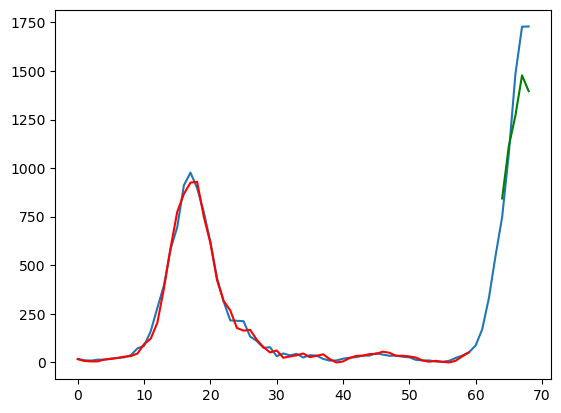

In [58]:
# plot
plt.plot(timeseries2[110:])
plt.plot(train_plot2[110:], c='r')
plt.plot(test_plot2[110:], c='g')
plt.show()

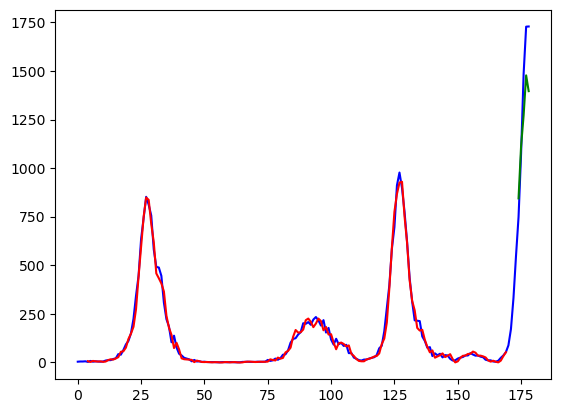

In [59]:
# plot
plt.plot(timeseries2,c='b')
plt.plot(train_plot2, c='r')
plt.plot(test_plot2, c='g')
# plt.plot(true_plot, c='b')

plt.show()

In [60]:
true_pred = torch.tensor(vrs.tail(len(vrs)+4).head(4)).unsqueeze(1).float()
true_pred.shape

torch.Size([4, 1])

In [61]:
true_predicted=[true_pred[-1].item()]
for i in range(5):
    last_sem = scaler.inverse_transform(model(torch.tensor(scaler.transform(true_pred[-4:])).float()).detach().numpy())[-1]
    true_predicted.append(last_sem[0].item())
    true_pred=torch.tensor(last_sem).reshape(1,1)
true_predicted

[5.0,
 5.557688236236572,
 4.06151819229126,
 2.478339672088623,
 0.8025519251823425,
 -0.9718897342681885]

In [62]:
true_pred_plot = np.ones(len(vrs))*np.nan
# true_plot[len(true_plot)-len(true_df)-1:len(true_plot)-1]=true_df
true_pred_plot.shape
for i in range(len(true_predicted)):
    true_pred_plot[-len(true_predicted)+i]=true_predicted[i]

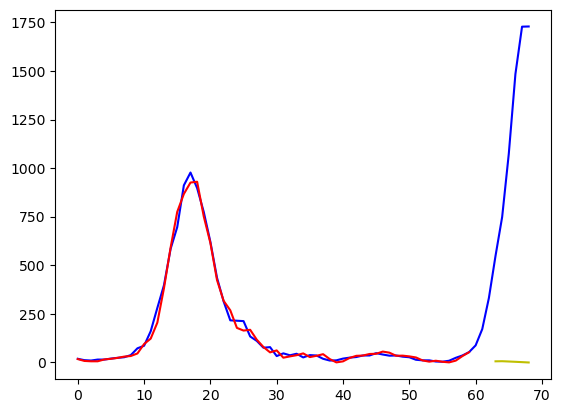

In [63]:
# plot
offset=110
plt.plot(timeseries2[offset:],c='b')
plt.plot(train_plot2[offset:], c='r')
# plt.plot(test_plot2, c='g')
# plt.plot(true_plot[offset:], c='b')
plt.plot(true_pred_plot[offset:], c='y')

plt.show()

In [64]:
#!pip install tensorflow==2.6.0

In [65]:
# !pip install tensorflow

# VRS

## SARIMA

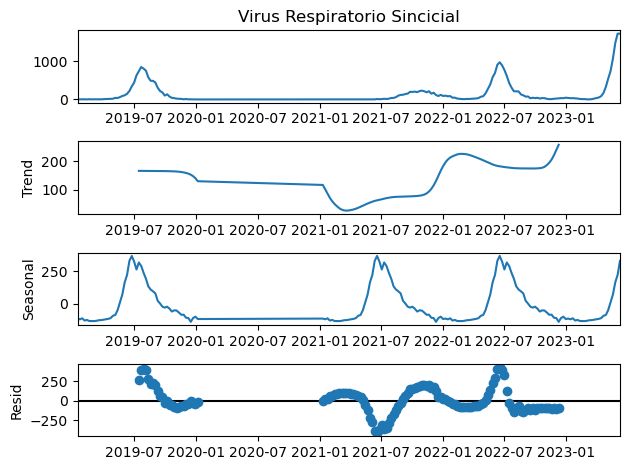

In [66]:
# Decompose the time series to visualize the trend and seasonality

# decomposition = seasonal_decompose(covid_train,)
decomposition = seasonal_decompose(vrs, period=52)
decomposition.plot()
plt.show()

In [67]:
# Fit a SARIMA model
# Note: p, d, q, P, D, Q, and S values need to be chosen based on your data.
# This example uses arbitrary values; for better results, it's essential to perform a grid search or similar to find optimal parameters.
p, d, q = 2, 1, 3  # Non-seasonal parameters
P, D, Q, S = 1, 1, 1, 4  # Seasonal parameters
sarima_model = SARIMAX(vrs, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_result = sarima_model.fit()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22298D+00    |proj g|=  1.18203D-01

At iterate    5    f=  5.18391D+00    |proj g|=  7.08466D-02

At iterate   10    f=  5.15534D+00    |proj g|=  2.98990D-02

At iterate   15    f=  5.13937D+00    |proj g|=  2.21390D-02

At iterate   20    f=  5.11758D+00    |proj g|=  2.00071D-02

At iterate   25    f=  5.09218D+00    |proj g|=  3.81958D-02

At iterate   30    f=  5.08788D+00    |proj g|=  4.94843D-04

At iterate   35    f=  5.08785D+00    |proj g|=  1.34400D-03

At iterate   40    f=  5.08767D+00    |proj g|=  1.75797D-03

At iterate   45    f=  5.08766D+00    |proj g|=  7.91016D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [68]:
# Make predictions
predict = sarima_result.predict()
# forecast_mean = forecast.predicted_mean
# forecast_conf_int = forecast.conf_int()

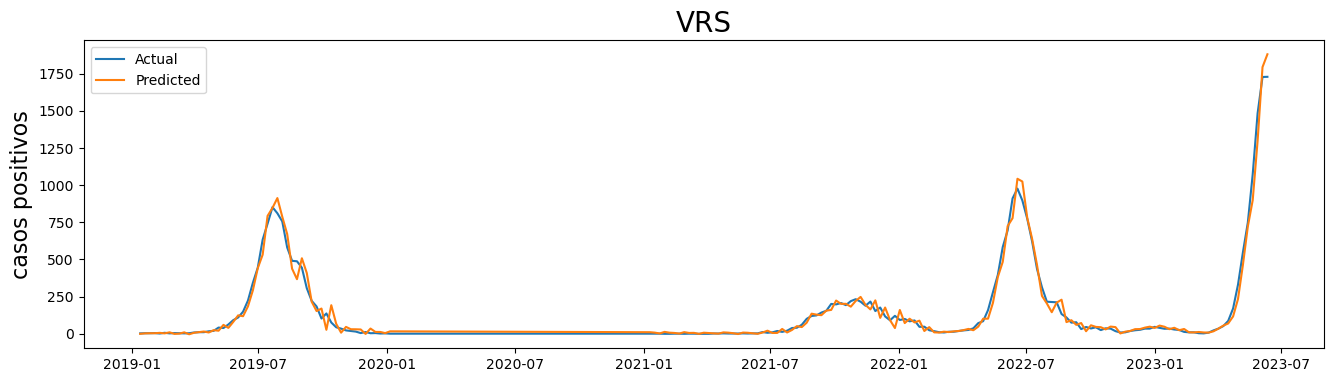

In [69]:
plt.figure(figsize=(16,4))
plt.plot(vrs, label="Actual")
plt.plot(predict, label="Predicted")
plt.title('VRS', fontsize=20)
plt.ylabel('casos positivos', fontsize=16)
plt.legend()

In [70]:
#forecast

forecast_weeks = 4
forecast = sarima_result.get_forecast(steps=forecast_weeks)
forecast_mean = forecast.predicted_mean

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [71]:
# Create a new index for the forecasted values based on the last date in the training data
last_date = vrs.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_weeks + 1, closed='right',freq='7D')
forecast_mean.index = forecast_dates

/tmp/ipykernel_6233/1946003586.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_weeks + 1, closed='right',freq='7D')


In [72]:
forecast_mean

2023-06-18    1661.916843
2023-06-25    1525.886746
2023-07-02    1347.692849
2023-07-09    1127.726295
Freq: 7D, Name: predicted_mean, dtype: float64

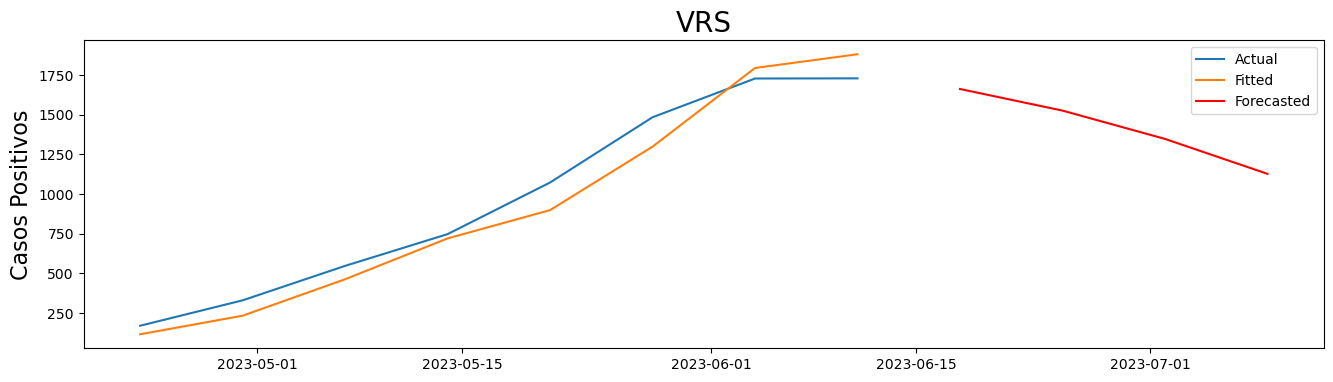

In [73]:
# Plot the results
plt.figure(figsize=(16, 4))
plt.plot(vrs.tail(8), label="Actual")
plt.plot(predict.tail(8), label="Fitted")
plt.plot(forecast_mean.index, forecast_mean.values, label="Forecasted", color='red')
# plt.plot(covid_test, label="True Future")
plt.title('VRS', fontsize=20)
plt.ylabel('Casos Positivos', fontsize=16)
plt.legend()
plt.show()

## LSTM

In [74]:
# largo = 158
# covid_df2 = covid_df.head(158)

In [75]:
# df = covid_df.reset_index()[['date','Número de confirmados']]
# timeseries = df[["Número de confirmados"]].values.astype('float32')


timeseries = vrs.values.astype('float32')

In [76]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries = scaler.fit_transform(timeseries.reshape(-1, 1))

In [77]:
# train-test split for time series8
train_size = int(len(timeseries) * 1)
# test_size = len(timeseries) - train_size
train= timeseries[:train_size]
 

In [78]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 

In [79]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
# X_test, y_test = create_dataset(test, lookback=lookback)
 

In [80]:
X_train.shape

torch.Size([175, 4, 1])

In [81]:
y_train.shape

torch.Size([175, 4, 1])

In [82]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=200, num_layers=1, batch_first=True)
        self.linear = nn.Linear(200, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 

In [ ]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=32)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
#     for X_batch, y_batch in loader:
    for batch, (X_batch,y_batch) in enumerate(loader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
#         print(y_pred.shape)
#         print('...')
#         print(y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
#         y_pred = model(X_test)
#         test_rmse = np.sqrt(loss_fn(y_pred, y_test))
#     print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))
 

Epoch 0: train RMSE 0.1532
Epoch 100: train RMSE 0.0296
Epoch 200: train RMSE 0.0282
Epoch 300: train RMSE 0.0275
Epoch 400: train RMSE 0.0268
Epoch 500: train RMSE 0.0263
Epoch 600: train RMSE 0.0258
Epoch 700: train RMSE 0.0255
Epoch 800: train RMSE 0.0253
Epoch 900: train RMSE 0.0252
Epoch 1000: train RMSE 0.0250
Epoch 1100: train RMSE 0.0250
Epoch 1200: train RMSE 0.0250
Epoch 1300: train RMSE 0.0254
Epoch 1400: train RMSE 0.0258
Epoch 1500: train RMSE 0.0248
Epoch 1600: train RMSE 0.0251
Epoch 1700: train RMSE 0.0248
Epoch 1800: train RMSE 0.0247
Epoch 1900: train RMSE 0.0246


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
#     test_plot = np.ones_like(timeseries) * np.nan
#     test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
    

# with torch.no_grad():
#     # shift train predictions for plotting
#     train_plot = np.ones_like(timeseries) * np.nan
#     y_pred = model(X_train)
#     print(y_pred.shape)
#     y_pred = y_pred[:, -1, :]
#     print(y_pred.shape)
#     train_plot[lookback+3:train_size] = model(X_train)[:, -1, 3].reshape(train_size-lookback-3,1)
#     # shift test predictions for plotting
#     test_plot = np.ones_like(timeseries) * np.nan
#     test_plot[train_size+lookback+3:len(timeseries)] =model(X_test)[:, -1, 3].reshape(test_size-lookback-3,1)
    
#     future_plot=model(y_test[-1])
    
    

In [ ]:
# invert
timeseries2 = scaler.inverse_transform(timeseries)
train_plot2 = scaler.inverse_transform(train_plot)
# test_plot2 = scaler.inverse_transform(test_plot)    
    
# plot
plt.plot(timeseries2)
plt.plot(train_plot2, c='r')
# plt.plot(test_plot2, c='g')
plt.show()

In [ ]:
# plot
plt.plot(timeseries2[70:])
plt.plot(train_plot2[70:], c='r')
# plt.plot(test_plot2[70:], c='g')
plt.show()

Predicción Futura

In [ ]:
true_pred = torch.tensor(vrs.tail(4)).unsqueeze(1).float()
true_pred.shape

In [ ]:
true_predicted=[true_pred[-1].item()]
for i in range(5):
    last_sem = scaler.inverse_transform(model(torch.tensor(scaler.transform(true_pred[-4:])).float()).detach().numpy())[-1]
    true_predicted.append(last_sem[0].item())
    true_pred=torch.tensor(last_sem).reshape(1,1)
true_predicted

In [ ]:
true_pred_plot = np.ones(len(vrs)+5)*np.nan
# true_plot[len(true_plot)-len(true_df)-1:len(true_plot)-1]=true_df
true_pred_plot.shape
for i in range(len(true_predicted)):
    true_pred_plot[-len(true_predicted)+i]=true_predicted[i]

In [ ]:
# plot
offset=130
plt.plot(timeseries2[offset:],c='b')
plt.plot(train_plot2[offset:], c='r')
# plt.plot(test_plot2, c='g')
# plt.plot(true_plot[offset:], c='b')
plt.plot(true_pred_plot[offset:], c='y')

plt.show()